In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.model_selection import train_test_split


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

from arch import arch_model


##import machine learning models

# Importing Linear Regression
from sklearn.linear_model import LinearRegression

# Importing Logistic Regression
from sklearn.linear_model import LogisticRegression

# Importing Decision Tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Importing Random Forest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor




In [21]:
daatasources={
    source.replace(".zip",""):source 
    for source in os.listdir("/Users/eduardomartinezacha/Desktop/coding/python/final material/project") 
    if source.endswith(".zip")}
daatasources

{'de-shareprices-daily': 'de-shareprices-daily.zip'}

In [22]:
datasets={}

for key, values in daatasources.items():
    datasets[key]= pd.read_csv(f"/Users/eduardomartinezacha/Desktop/coding/python/final material/project/{values}",sep=';')

In [23]:
import pandas as pd

datasets = {}

for key, values in daatasources.items():
    datasets[key] = pd.read_csv(f"/Users/eduardomartinezacha/Desktop/coding/python/final material/project/{values}", sep=';')

# Combine all DataFrames into one
df = pd.concat(datasets.values(), ignore_index=True)

vals=['VOW.DE','MBG.DE','BMW.DE','DRI.DE','DTE.DE']
df=df[df['Ticker'].isin(vals)]
df['Date']=pd.to_datetime(df['Date'])

df['Price_Changes']= df['Open']- df['Close']
df=pd.DataFrame(df)
df['Ticker'].unique()
df['log_returns']= np.log(df['Close']/df['Close'].shift(1)) *100
df['log_returns']=df['log_returns'].dropna()

df['Ticker'].unique()

df=df[df['log_returns'].notnull()]
df

,Ticker,SimFinId,Date,Open,High,Low,Close,Adj. Close,Volume,Dividend,Shares Outstanding,Price_Changes,log_returns
7519,BMW.DE,825112,2019-04-09,82.38,83.43,82.11,82.46,58.45,1281897,NaN,660000000.0,-0.08,-0.423550
7520,BMW.DE,825112,2019-04-10,82.25,82.97,82.19,82.53,58.49,1264318,NaN,660000000.0,-0.28,0.084854
7521,BMW.DE,825112,2019-04-11,82.57,83.15,81.94,82.78,58.67,1287851,NaN,660000000.0,-0.21,0.302462
7522,BMW.DE,825112,2019-04-12,82.63,85.51,82.22,85.22,60.40,2612728,NaN,660000000.0,-2.59,2.904966
7523,BMW.DE,825112,2019-04-15,84.93,85.90,84.68,85.52,60.60,1175155,NaN,660000000.0,-0.59,0.351412
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39091,VOW.DE,858327,2024-03-04,151.77,155.35,151.72,154.65,144.63,55049,NaN,501295263.0,-2.88,2.176770
39092,VOW.DE,858327,2024-03-05,153.38,153.49,148.23,150.56,140.81,53480,NaN,501295263.0,2.82,-2.680282
39093,VOW.DE,858327,2024-03-06,150.56,151.05,147.63,148.23,138.63,47456,NaN,501295263.0,2.33,-1.559655
39094,VOW.DE,858327,2024-03-07,147.02,147.57,145.17,147.02,137.51,38560,NaN,501295263.0,0.00,-0.819649


In [24]:

bmw=df[df['Ticker']=='BMW.DE']
dri=df[df['Ticker']=='DRI.DE']
dte=df[df['Ticker']=='DTE.DE']
mbg=df[df['Ticker']=='MBG.DE']
vow=df[df['Ticker']=='VOW.DE']
bmw.to_csv('bmw_csv')

In [25]:
bmw_training_data= bmw[bmw['Date']<'2024-02-20']
bmw_testing_data=bmw[bmw['Date']>'2024-02-20']

vow_training_data= vow[vow['Date']<'2024-02-20']
vow_testing_data=vow[vow['Date']>'2024-02-20']

mbg_training_data= mbg[mbg['Date']<'2024-02-20']
mbg_testing_data=mbg[mbg['Date']>'2024-02-20']

In [26]:
##for bmw
gjr_garch_vow_aic_bic=arch_model(bmw_training_data['log_returns'] ,vol='GARCH',p=1,q=1,o=2,dist='t').fit(disp='off') 
forecast_bmw_model=gjr_garch_vow_aic_bic.forecast(horizon=13, method='simulation')
bmw_pred_vals= forecast_bmw_model.variance.iloc[-1] **0.5
df_bmw=pd.DataFrame({'Date':bmw_testing_data['Date'],'Vals':bmw_pred_vals.values})
##for vow 
model_garch_jr_vow_aic=arch_model(vow_training_data['log_returns'], vol='GARCH',p=1, q=1,dist='t').fit(disp='off') 
forecast_vow_model=gjr_garch_vow_aic_bic.forecast(horizon=13)
vow_pred_vals= forecast_vow_model.variance.iloc[-1]**0.5
df_vow=pd.DataFrame({'Date':vow_testing_data['Date'],'Vals':vow_pred_vals.values})
##for mercedes
mbg_egarch_aic = arch_model(mbg_training_data['log_returns'], vol='EGARCH',p=8, q=1, dist='t').fit(disp='off')  # 
forecast_mbg_model=mbg_egarch_aic.forecast(horizon=13,method='simulation')
mbg_pred_vals= forecast_mbg_model.variance.iloc[-1]**0.5
df_mbg= pd.DataFrame({'Date':mbg_testing_data['Date'],'Vals':mbg_pred_vals.values})

- plots for three models

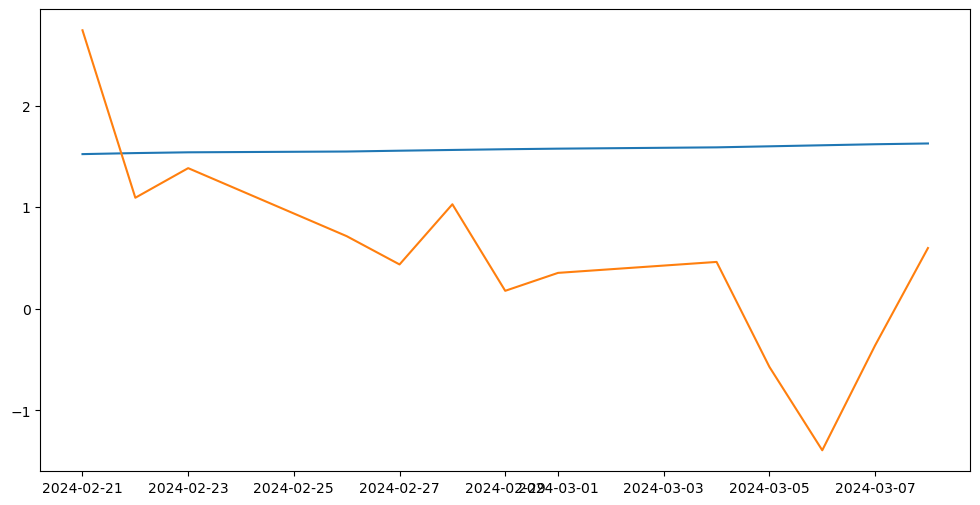

In [27]:
plt.figure(figsize=(12,6))
plt.plot(df_bmw['Date'],df_bmw['Vals'])
plt.plot(bmw['Date'].iloc[-13:],bmw['log_returns'].iloc[-13:])

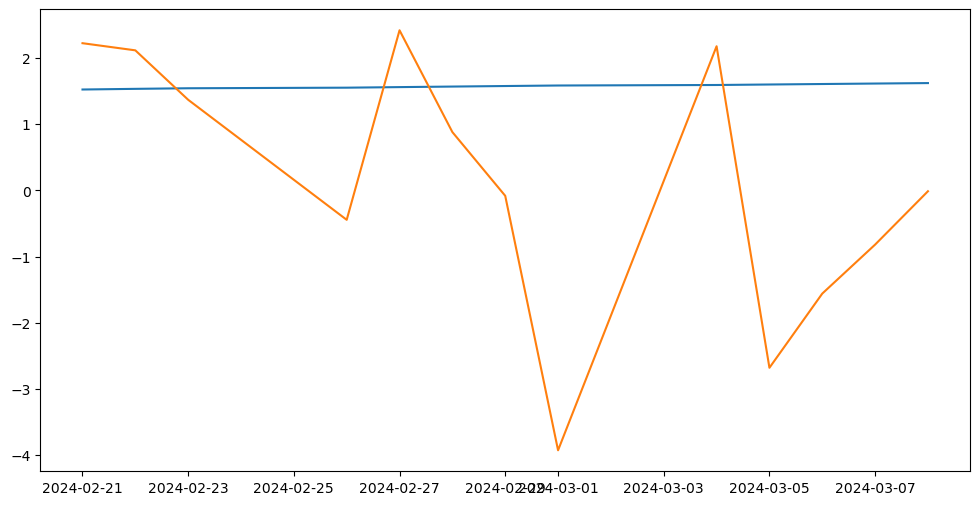

In [28]:
plt.figure(figsize=(12,6))
plt.plot(df_vow['Date'],df_vow['Vals'])
plt.plot(vow['Date'].iloc[-13:],vow['log_returns'].iloc[-13:])

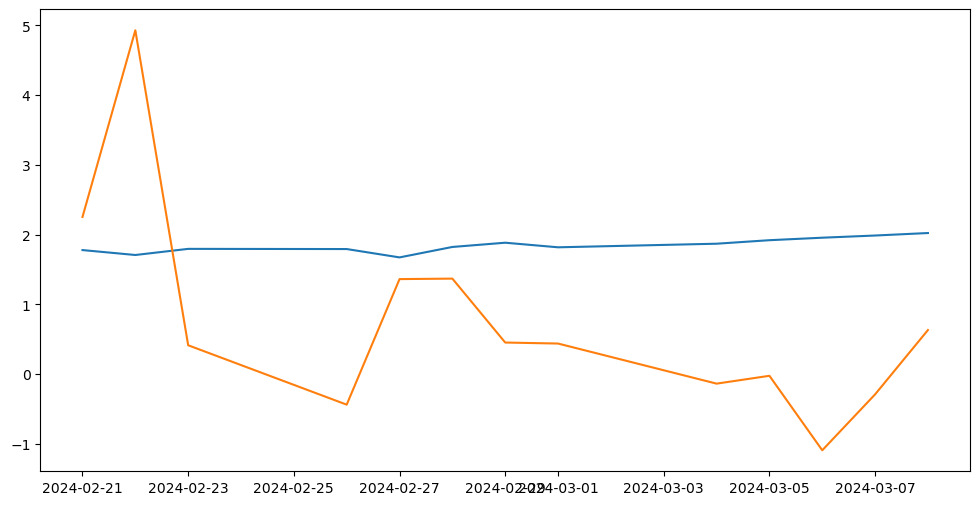

In [29]:
plt.figure(figsize=(12,6))
plt.plot(df_mbg['Date'],df_mbg['Vals'])
plt.plot(mbg['Date'].iloc[-13:],mbg['log_returns'].iloc[-13:])

In [31]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_result = adfuller(bmw_training_data['log_returns'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

# Interpretation
if adf_result[1] < 0.05:
    print("Log returns are stationary ✅")
else:
    print("Log returns are NOT stationary ⚠️ - Consider demeaning.")


ADF Statistic: -14.585416893184993
p-value: 4.3999821079896426e-27
Log returns are stationary ✅


ADF Test Statistic: -14.647240073968433
P-Value: 3.546536755605243e-27
        Model          AIC          BIC
0     ARCH(1)  5348.549922  5363.947414
1  GARCH(1,1)  5126.866249  5147.396239


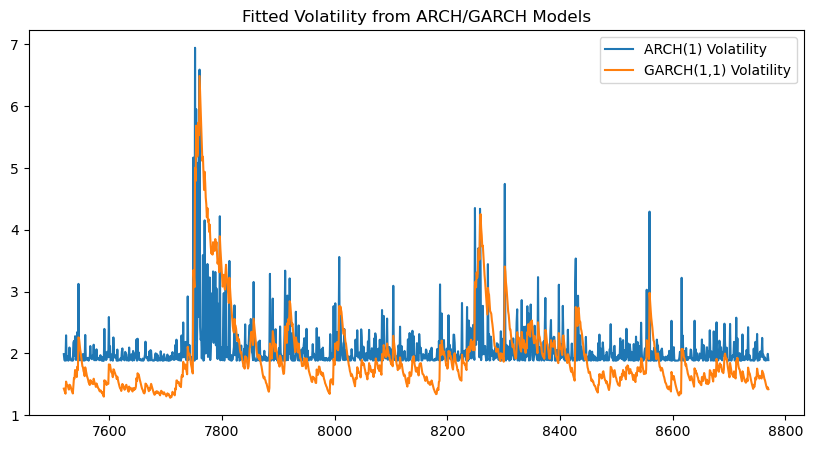

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.stattools import adfuller

# Load your data (assuming you have the same dataset format)


# Extract log returns and drop NaN values
log_returns = bmw["log_returns"].dropna()

# Check for stationarity
adf_result = adfuller(log_returns)
print(f"ADF Test Statistic: {adf_result[0]}")
print(f"P-Value: {adf_result[1]}")

# Fit an ARCH(1) model
arch_model_1 = arch_model(log_returns, vol='ARCH', p=1)
arch_result_1 = arch_model_1.fit(disp="off")

# Fit a GARCH(1,1) model
garch_model_1_1 = arch_model(log_returns, vol='GARCH', p=1, q=1)
garch_result_1_1 = garch_model_1_1.fit(disp="off")

# Compare AIC/BIC values
arch_aic = arch_result_1.aic
garch_aic = garch_result_1_1.aic

arch_bic = arch_result_1.bic
garch_bic = garch_result_1_1.bic

# Display results
model_comparison = pd.DataFrame({
    "Model": ["ARCH(1)", "GARCH(1,1)"],
    "AIC": [arch_aic, garch_aic],
    "BIC": [arch_bic, garch_bic]
})

print(model_comparison)

# Plot the fitted volatility
plt.figure(figsize=(10,5))
plt.plot(arch_result_1.conditional_volatility, label="ARCH(1) Volatility")
plt.plot(garch_result_1_1.conditional_volatility, label="GARCH(1,1) Volatility")
plt.legend()
plt.title("Fitted Volatility from ARCH/GARCH Models")
plt.show()


- class code that gbt gave me 

In [35]:
import pandas as pd
from arch import arch_model

class GARCHForecasterforbmw:
    def __init__(self, log_returns, p=1, q=1, o=2, forecast_horizon=2):
        """
        Initialize the GARCH forecaster.
        :param log_returns: Series of log returns
        :param p: Lag order for past variances
        :param q: Lag order for past squared returns
        :param forecast_horizon: Number of days to forecast ahead
        """
        self.log_returns = log_returns.dropna()
        self.p = p
        self.q = q
        self.o=o
        self.forecast_horizon = forecast_horizon
        self.model = None
        self.fitted_model = None
    
    def fit_model(self):
        """Fits a GARCH model to the log returns."""
        self.model = arch_model(self.log_returns, vol="GARCH", p=self.p, q=self.q,o=self.o)
        self.fitted_model = self.model.fit(disp="off")
    
    def forecast_volatility(self):
    
        if self.fitted_model is None:
            raise ValueError("Model not fitted. Call fit_model() first.")

    # Get forecasts
        forecasts = self.fitted_model.forecast(horizon=self.forecast_horizon)

    # Debug: Print forecasts DataFrame
        print("\nDEBUG: Forecasted Variance DataFrame")
        print(forecasts.variance)

    # Ensure there's data before accessing last row
        if forecasts.variance.empty:
            raise ValueError("Forecasted variance is empty. Check the model input data.")

    # Extract variance safely
        try:
             predicted_variance = forecasts.variance.iloc[-1]  # Last available row
        except IndexError:
                predicted_variance = forecasts.variance.iloc[0]  # Fallback to first row

    # Convert variance to volatility (standard deviation)
        predicted_volatility = predicted_variance ** 0.5  

        return predicted_volatility

    def update_data(self, new_log_return):
         self.log_returns = pd.concat([self.log_returns, pd.Series([new_log_return])], ignore_index=True).dropna()


    def retrain_model(self):
        """Re-trains the GARCH model with the updated data."""
        self.fit_model()



In [36]:

import numpy as np

# Create a sample log_returns Series (Replace this with your actual data)
log_returns =  bmw['log_returns']

# Initialize the GARCH forecaster
forecaster = GARCHForecaster(log_returns)

# Train the model
forecaster.fit_model()

# Forecast volatility for tomorrow
predicted_volatility = forecaster.forecast_volatility()
print("Predicted Volatility:", predicted_volatility)

# Simulate new daily return
new_log_return = np.random.randn() * 0.01

# Update dataset and retrain
forecaster.update_data(new_log_return)
forecaster.retrain_model()

# Forecast again after retraining
new_predicted_volatility = forecaster.forecast_volatility()
print("New Predicted Volatility:", new_predicted_volatility)


DEBUG: Forecasted Variance DataFrame
           h.1       h.2
8770  1.856308  1.867061
Predicted Volatility: h.1    1.362464
h.2    1.366404
Name: 8770, dtype: float64

DEBUG: Forecasted Variance DataFrame
           h.1       h.2
1252  1.797859  1.811003
New Predicted Volatility: h.1    1.340843
h.2    1.345735
Name: 1252, dtype: float64
